# Introduction to (Deep) Generative Models

Generative models are unsupervised ML algorithms, which means that the input data (usually) does not contain labels. Based on the input representation, generative models learn data distribution, which enables generation of novel examples that are similar to those observed in the training.

A typical application of generative models is image, text, or compound generation. Several classes of generative models based on neural networks are presented below.

1. **Autoencoder** - a model that consists of two networks, an encoder and decoder. The encoder takes the input representation of data and transforms it into a lower-dimensional latent representation (numerical vector). The decoder uses encoded vectors to reconstruct the initial data representation. We can write that $x'=D(E(x))$, and the optimization target is to minimize the difference between the input object $x$ and the reconstructed object $x'$, so the loss function can be $\mathcal{L}=\|x-x' \|_2$ in the case of simple numerical objects as for example images. To make this model generative, the latent space is additionally constrained to follow the Gaussian distribution, i.e. $\mathcal{L}=\|x-x' \|_2 + \mathcal{L}_{normal}(E(x))$. Then, if we sample a latent vector $z\sim \mathcal{N}(0, 1)$ and transform it using the decoder $x'=D(z)$, we will obtain a new generated object.
![](https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png)
2. **Recurrent neural network (autoregressive modeling)** - a type of neural network in which a partial output is used as the input to the next segment of the network. Recurrent neural networks generate objects by growing object fragments, e.g. texts can be generated word-by-word, and molecules can be created by adding atoms iteratively. The intermediate steps of the generative process are used as the input to the model which decides about the next generation step.
![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Gated_Recurrent_Unit.svg)

# How generative models are used to design new drugs

There are two ways in which generative models can be applied in drug design. We can generate compounds from scratch, and we call this process *de novo* drug design. The other application is optimization of existing molecules, e.g. during the **lead optimization** stage of drug discovery where our promising compound (so called lead) is modified to increase the activity or optimize other molecular properties (ADMET).

Two types of generators can be used to invent new compounds: those based on **SMILES** and those based on **molecular graphs**. We can generate a SMILES sequence, but this representation is prone to produce invalid molecules (SMILES has a strict grammar), on top of other shortcomings discussed when introducing SMILES predictive models. Graph generation seems more reasonable, but this approach also has some downsides:

1. Sequential atom-by-atom generation leads to **incorrect intermediate states**. For example, to generate a ring, we need to first generate a long chain of atoms that is closed in the last step. One possible solution to this problem is fragment-based design where we expand molecules by attaching whole structures (e.g. rings) instead of single atoms.
2. Molecular graphs are **discrete structures** meaning that atoms and bonds are defined by binary features. We cannot generate partial bonds or mixed atom symbols. Hence, the continuous output of a neural network needs to be converted to a discrete structure, e.g. an adjacency matrix should be rounded to contain only zeros and ones. By discretizing outputs, we lose differentiability of the network, so we can apply the loss function only to the incorrect continuous representation of the molecule before rounding all the numbers. There are some solutions to this problem, e.g. Gumbel Softmax is a technique that allows to preserve the differentiability of the rounding operation. We can also use reinforcement learning that does not require the network to be differentiable (the gradients are calculated in a different way, based on a reward function).

Another factor we need to consider when designing drugs is optimization of molecular properties. Not only do we want to generate correct compounds, but also we need these molecules to be synthesizable and possess all the desirable properties. Tp that end, additional learning terms are often included in the generative process.

# SMILES-based generative model: ReLeaSE

Code repo: https://github.com/isayev/ReLeaSE ([Paper](https://www.science.org/doi/epdf/10.1126/sciadv.aap7885))

**TL;DR**

In this paper, a SMILES generator is implemented. Because SMILES follows certain grammar rules, and it is "almost" a context-free grammar, for which there exists a pushdown automaton that accepts this grammar. A stack is needed for the model to remember, e.g., opening of parentheses that denote atom branches or numbers that denote ring closures. By adding a stack to a recurrent neural network (e.g. GRU), we can improve the validity of generated SMILES strings. Additionally, molecular properties of the generated compounds can be optimized by employing a predictive model that calculates the value of a reward function. The reward is calculated when the full SMILES string is generated. Model parameters are corrected using reinforcement learning, and more precisely the REINFORCE algorithm.

In [25]:
!git clone https://github.com/isayev/ReLeaSE.git

In [2]:
import sys
sys.path.append('ReLeaSE/release')

In [3]:
import torch
from rdkit import Chem

In [4]:
from stackRNN import StackAugmentedRNN
from data import GeneratorData

use_cuda = False

In [26]:
hidden_size = 50
stack_width = 50
stack_depth = 10
lr = 0.001
optimizer_instance = torch.optim.Adadelta
layer_type = 'GRU'

gen_data_path = 'ReLeaSE/data/logP_labels.csv'
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter=',',
                         cols_to_read=[1], keep_header=False)

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters,
                                 hidden_size=hidden_size,
                                 output_size=gen_data.n_characters,
                                 layer_type=layer_type,
                                 n_layers=1, is_bidirectional=True,
                                 has_stack=True,
                                 stack_width=stack_width,
                                 stack_depth=stack_depth,
                                 use_cuda=use_cuda,
                                 optimizer_instance=optimizer_instance,
                                 lr=lr)
if use_cuda:
    my_generator = my_generator.cuda()

losses = my_generator.fit(gen_data, 1000)

my_generator.evaluate(gen_data)

In [8]:
gen_data_path = 'ReLeaSE/data/chembl_22_clean_1576904_sorted_std_final.smi'
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

model = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=1500,
                                     output_size=gen_data.n_characters, 
                                     layer_type='GRU',
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=1500, stack_depth=10, 
                                     use_cuda=use_cuda)

if use_cuda:
    model.load_model('ReLeaSE/checkpoints/generator/checkpoint_biggest_rnn')
else:
    weights = torch.load('ReLeaSE/checkpoints/generator/checkpoint_biggest_rnn', map_location=torch.device('cpu'))
    model.load_state_dict(weights)

Random Smile:  Fc1ccc2ncnc(NN3CCCC3=O)c2c1


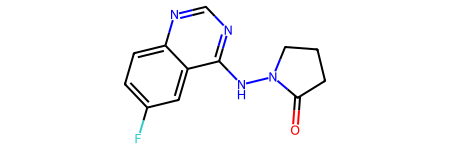

In [18]:
smiles = model.evaluate(gen_data)[1:-1]

print('Random Smile: ', smiles)
mol = Chem.MolFromSmiles(smiles)
if mol:
    display(mol)
else:
    print('Invalid SMILES!')

# Graph-based generative model: JT-VAE

Code repo: https://github.com/Bibyutatsu/FastJTNNpy3 ([Paper](https://arxiv.org/pdf/1802.04364.pdf))

**TL;DR**

JT-VAE is an autoencoder working on molecular graphs. To facilitate compound generation, structural formulas are converted to so-called junction trees, in which rings are transformed into single nodes. This way, instead of a graph, we obtain a tree structure that can be decoded to a compound. The graph encoder is a graph neural network (MPNN), and the tree encoder is a similar architecture, but only passes messages from the root to the leaves. The tree decoder is a recurrent neural network (GRU) that builds a tree in the DFS order. The graph decoder is used to correctly connect atoms after decoding tree nodes - rings have multiple possible attachment points. To optimize molecular properties, we can use Bayesian search of the encoded latent space.

In [27]:
!git clone https://github.com/Bibyutatsu/FastJTNNpy3.git

import sys
use_cuda = False
sys.path.append('FastJTNNpy3')

In [5]:
import fnmatch, os

if not use_cuda:
    for path, dirs, files in os.walk(os.path.abspath("FastJTNNpy3")):
        for filename in fnmatch.filter(files, "*.py"):
            filepath = os.path.join(path, filename)
            with open(filepath) as f:
                s = f.read()
            s = s.replace(".cuda()", "")
            with open(filepath, "w") as f:
                f.write(s)

In [28]:
from rdkit import Chem
import torch

from fast_jtnn import *
import rdkit

def load_model(vocab, model_path, hidden_size=450, latent_size=56, depthT=20, depthG=3, use_cuda=True):
    vocab = [x.strip("\r\n ") for x in open(vocab)] 
    vocab = Vocab(vocab)

    model = JTNNVAE(vocab, hidden_size, latent_size, depthT, depthG)
    if use_cuda:
        dict_buffer = torch.load(model_path)
    else:
        dict_buffer = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(dict_buffer)
    if use_cuda:
        model = model.cuda()

    torch.manual_seed(0)
    return model

model = load_model('FastJTNNpy3/data/vocab.txt', 'FastJTNNpy3/fast_molvae/vae_model/model.epoch-19', use_cuda=use_cuda)

[11:10:55] Explicit valence for atom # 1 C, 5, is greater than permitted
[11:10:55] Explicit valence for atom # 1 C, 5, is greater than permitted


Random Smile:  CON1C=CC=CC1C(=O)Nc1ccccc1[N+](=O)[O-]


[11:10:56] Explicit valence for atom # 1 C, 5, is greater than permitted


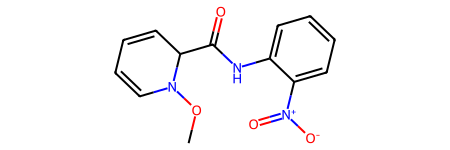

In [24]:
z = torch.randn(1, 56//2)
smiles = model.decode(z, z, False)
print('Random Smile: ', smiles)
Chem.MolFromSmiles(smiles)

**Exercise:** Use one of the models above to optimize LogP of the generated compounds. There are many possible solutions. For example you can use notebooks in the ReLeaSE repo which demonstrate how REINFORCE can be used to tune the generator, or you can use Bayesian search in the latent space of JT-VAE. The expected result is a shift of LogP distribution in the generated sample.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns


# Write generated samples to the dataframe below. In the "model" column, you should specify which model generated this sample.
# For example, you can use "pre" for unconstrained generation and "post" for optimized logP
df = pd.DataFrame({'smiles': ..., 'LogP': ..., 'model': ...})

<Axes: xlabel='LogP', ylabel='Density'>

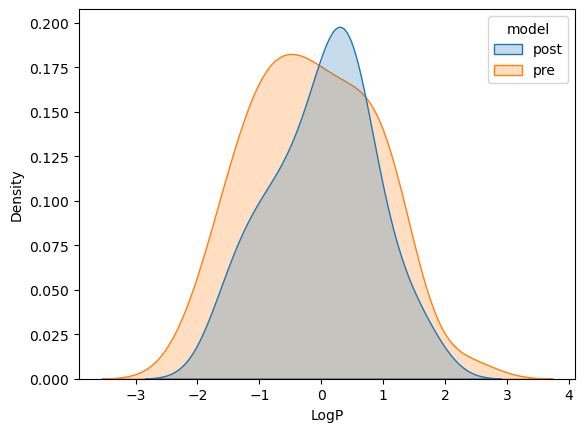

In [30]:
sns.kdeplot(data=df, x='LogP', hue='model', fill=True)